In [46]:

# Importing libraries

%matplotlib inline

import pandas_datareader as pdr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics as stats
import math
from scipy.stats import norm
import statsmodels.api as sm
import requests
from io import BytesIO
import datetime as dt

#import alpaca_trade_api as tradeapi


In [47]:

# Set Data Date

start = dt.datetime(2000, 1, 1)
end = dt.datetime(2020, 1, 1)


In [48]:

# Download Data

spy_df = pdr.get_data_yahoo(symbols='SPY', start = start, end = end)
vix_df = pdr.get_data_yahoo(symbols='^VIX', start = start, end = end)


In [5]:
# spy_df = spy_df.resample('D').asfreq()
# vix_df = vix_df.resample('D').asfreq()

In [49]:

# Calculate Daily Returns

spy_df['Daily Return'] = (spy_df['Adj Close'] / spy_df['Adj Close'].shift(1)) -1
spy_df.dropna(inplace = True)


In [50]:

# Fit the markov model

mod_spy_df = sm.tsa.MarkovAutoregression(spy_df['Daily Return'], k_regimes = 2, order = 1, switching_ar = True)
res_spy_df = mod_spy_df.fit()


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [106]:

# Get the results

res_spy_df.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                         Markov Switching Model Results                         
================================================================================
Dep. Variable:             Daily Return   No. Observations:                 5029
Model:             MarkovAutoregression   Log Likelihood               15305.323
Date:                  Thu, 22 Oct 2020   AIC                         -30596.646
Time:                          10:55:20   BIC                         -30550.986
Sample:                               0   HQIC                        -30580.648
                                 - 5029                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0031      0.001     -3.080      0.002      -0.005      -0.001
ar.L1          1.0000      0.078     12.874      0.000       0.848       1.152
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.000      5.079      0.000       0.001       0.001
ar.L1         -0.1966      0.018    -10.928      0.000      -0.232      -0.161
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0001   2.67e-06     44.791      0.000       0.000       0.000
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.0748      0.033      2.254      0.024       0.010       0.140
p[1->0]        0.1257      0.025      5.019      0.000       0.077       0.175
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

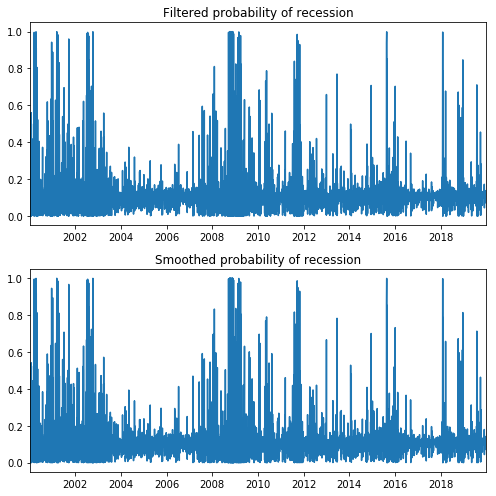

In [52]:

# Plot the probabilties

fig, axes = plt.subplots(2, figsize=(7,7))

ax = axes[0]
ax.plot(res_spy_df.filtered_marginal_probabilities[0])
ax.set_xlim(spy_df.index[4], spy_df.index[-1])
ax.set(title = 'Filtered probability of recession')

ax = axes[1]
ax.plot(res_spy_df.smoothed_marginal_probabilities[0])
ax.set_xlim(spy_df.index[4], spy_df.index[-1])
ax.set(title = 'Smoothed probability of recession')

fig.tight_layout()

In [53]:

# Get the expected duration

print(res_spy_df.expected_durations)


[1.08085332 7.953931  ]


In [54]:

# Adding Bollinger Bands as technical indicator for portfolio rebalancing

spy_df['20 day moving average'] = spy_df['Adj Close'].rolling(window=20).mean()

spy_df['20 day std'] = spy_df['Adj Close'].rolling(window=20).std()

spy_df['Upper Band'] = spy_df['20 day moving average'] + (spy_df['20 day std'] * 1.5)
spy_df['Lower Band'] = spy_df['20 day moving average'] - (spy_df['20 day std'] * 1.5)


In [55]:

# Setup Call & Put functions
def d_1(sigma, T, S, K, r):
    return 1/(sigma*np.sqrt(T))*(np.log(S/K)+(r+(sigma**2)/2)*T)

def d_2(d_1, sigma, T):
    return d_1 - sigma*np.sqrt(T)

def Call(sigma, T, S, K, r):
    d1 = d_1(sigma, T, S, K, r)
    d2 = d_2(d1, sigma, T)
    return norm.cdf(d1)*S-norm.cdf(d2)*K*np.exp(-r*T)

def Put(sigma, T, S, K, r):
    d1 = d_1(sigma, T, S, K, r)
    d2 = d_2(d1, sigma, T)
    return norm.cdf(-d2)*K*np.exp(-r*T)-norm.cdf(-d1)*S


State: 0.0
option invested on 2000-02-18 00:00:00 premium: 2.7637636517636324 option type: c direction: l
Option expires 2000-03-20 00:00:00 return: 7.621864318847656
State: 0.0
option invested on 2000-03-21 00:00:00 premium: 2.553359991391332 option type: p direction: l
Option expires 2000-04-24 00:00:00 return: 4.713569641113281
State: 0.0
option invested on 2000-05-23 00:00:00 premium: 2.8117946885558354 option type: c direction: l
Option expires 2000-06-23 00:00:00 return: 4.562347412109375
State: 0.0
option invested on 2000-06-29 00:00:00 premium: 2.247572667600231 option type: c direction: l
Option expires 2000-07-31 00:00:00 return: 0
State: 0.0
option invested on 2000-08-17 00:00:00 premium: 2.0797552187859765 option type: p direction: l
Option expires 2000-09-18 00:00:00 return: 3.51947021484375
State: 0.0
option invested on 2000-09-19 00:00:00 premium: 2.262703241308621 option type: c direction: l
Option expires 2000-10-20 00:00:00 return: 0
State: 0.0
option invested on 2000

option invested on 2006-10-24 00:00:00 premium: 1.3089871969909197 option type: p direction: l
Option expires 2006-11-24 00:00:00 return: 0
State: 0.0
option invested on 2006-12-04 00:00:00 premium: 1.3964154753402127 option type: p direction: l
Option expires 2007-01-04 00:00:00 return: 0
State: 0.0
option invested on 2007-01-12 00:00:00 premium: 1.2888734365292578 option type: p direction: l
Option expires 2007-02-12 00:00:00 return: 0
State: 0.0
option invested on 2007-02-14 00:00:00 premium: 1.3203415740779292 option type: p direction: l
Option expires 2007-03-19 00:00:00 return: 3.6714630126953125
State: 0.0
option invested on 2007-03-23 00:00:00 premium: 1.6463193044813238 option type: p direction: l
Option expires 2007-04-23 00:00:00 return: 0
State: 0.0
option invested on 2007-04-25 00:00:00 premium: 1.7502150365932891 option type: p direction: l
Option expires 2007-05-29 00:00:00 return: 0
State: 0.0
option invested on 2007-05-30 00:00:00 premium: 1.746066164332511 option type

State: 0.0
option invested on 2013-01-29 00:00:00 premium: 2.010076267745461 option type: p direction: l
Option expires 2013-03-01 00:00:00 return: 0
State: 0.0
option invested on 2013-03-05 00:00:00 premium: 2.084440956929754 option type: p direction: l
Option expires 2013-04-05 00:00:00 return: 0
State: 0.0
option invested on 2013-04-09 00:00:00 premium: 2.0274647366168352 option type: p direction: l
Option expires 2013-05-10 00:00:00 return: 0
State: 0.0
option invested on 2013-05-14 00:00:00 premium: 2.1256620388144825 option type: p direction: l
Option expires 2013-06-14 00:00:00 return: 1.7686309814453125
State: 0.0
option invested on 2013-06-21 00:00:00 premium: 3.0306826550545622 option type: c direction: l
Option expires 2013-07-22 00:00:00 return: 9.045867919921875
State: 0.0
option invested on 2013-08-02 00:00:00 premium: 2.076054346956127 option type: p direction: l
Option expires 2013-09-03 00:00:00 return: 5.6894378662109375
State: 0.0
option invested on 2013-09-10 00:00:

State: 0.0
option invested on 2019-01-18 00:00:00 premium: 5.337085395946346 option type: p direction: l
Option expires 2019-02-19 00:00:00 return: 0
State: 0.0
option invested on 2019-02-20 00:00:00 premium: 4.404413473542263 option type: p direction: l
Option expires 2019-03-25 00:00:00 return: 0
State: 0.0
option invested on 2019-04-01 00:00:00 premium: 4.343472929191876 option type: p direction: l
Option expires 2019-05-02 00:00:00 return: 0
State: 0.0
option invested on 2019-05-03 00:00:00 premium: 4.293753038310086 option type: p direction: l
Option expires 2019-06-03 00:00:00 return: 18.9111328125
State: 0.0
option invested on 2019-06-10 00:00:00 premium: 5.212239552106865 option type: p direction: l
Option expires 2019-07-11 00:00:00 return: 0
State: 0.0
option invested on 2019-07-12 00:00:00 premium: 4.249556568381337 option type: p direction: l
Option expires 2019-08-12 00:00:00 return: 12.284576416015625
State: 0.0
option invested on 2019-08-14 00:00:00 premium: 7.1112185129

In [56]:
pf_df.plot()

NameError: name 'pf_df' is not defined

In [1]:
# Object-oriented solution

In [99]:
class option:
    def __init__(self, opt_type, opt_dir, opt_strike, opt_exp, opt_reg):
        self.opt_type = opt_type
        self.opt_dir = opt_dir
        self.opt_strike = opt_strike
        self.opt_exp = opt_exp
        self.opt_reg = opt_reg
        self.state = 'invested'
    
    def option_payout(self, S):
        """
        Calculates an option pay-out depending on direction (long/short),
        option type (call/put), current underlying level (S) and the option's strike (K)
        """
        setattr(self, 'state', 'expired')        
        if self.opt_dir == "s":
            if self.opt_type == "p":
                return -max(0, self.opt_strike-S)
            else:
                return -max(0, S-self.opt_strike)
        else:
            if self.opt_type == "p":
                return max(0, self.opt_strike-S)
            else:
                return max(0, S-self.opt_strike)

    def option_premium(self, vola, cur_date, cur_close):
        if self.opt_type == "p":
            prem = Put(vola, timediff(self.opt_exp, cur_date), cur_close, self.opt_strike, 0.005)
        else:
            prem = Call(vola, timediff(self.opt_exp, cur_date), cur_close, self.opt_strike, 0.005)
        if self.opt_dir == "l":
            return -prem
        else:
            return prem
    
    pass

In [43]:
a = option ("p", "l", 50, 40)

In [94]:
def timediff(date1, date2):
    """
    Little helper function to calculate 30/360 yearfrac for calculating
    """
    return (date1.day + date1.month * 30 + date1.year * 360 - (date2.day + date2.month * 30 + date2.year * 360))/360

In [111]:
# Initial investment state = 0 (not invested)
inv_state = 0

# Setting initial portfolio value to 0
pf_value = 0

# Creating list to keep track of portfolio values
pf_value_list = []

# Create portfolio dataframe with underlyings date index
pf_df = pd.DataFrame(index=spy_df.index)

# Looping through the data and short put options

for day in range(len(spy_df)):
    # Keeping track of every day's portfolio value
    pf_value_list.append(pf_value)
    cur_close = spy_df["Adj Close"].iloc[day]
    
    # Set regime state according to smoothed marginal probabilities
    # (0 = low vol | 1 = high vol)
    if spy_df.index[day] >= res_spy_df.smoothed_marginal_probabilities.index[0]:
        reg_state = round(res_spy_df.smoothed_marginal_probabilities.loc[spy_df.index[day]][0])

    # Expiry of options
    if inv_state == 1 and spy_df.index[day] > new_option.opt_exp:
        # Calculating option premium at expiry
        opt_return = new_option.option_payout(spy_df["Adj Close"].iloc[day])
        print("Option expires", spy_df.index[day], "return:", opt_return)

        # Adding expiry value to portfolio value
        pf_value += opt_return

        # Setting investment state to "not invested" = 0
        inv_state = 0

    # High vol and above upper band -> short call
    if cur_close > spy_df["Upper Band"].iloc[day] and reg_state == 1:
        print("State:", reg_state)
        
        if inv_state == 1 and new_option.opt_reg != reg_state:
            #Book out existing option
            pf_value -= new_option.option_premium(vix_df["Adj Close"].loc[spy_df.index[day]] / 100, spy_df.index[day], cur_close)
            
            # Create new option
            new_option = option("c", "s", cur_close, spy_df.index[day] + dt.timedelta(days=30), reg_state)
            opt_prem = new_option.option_premium(vix_df["Adj Close"].loc[spy_df.index[day]] / 100, spy_df.index[day], cur_close)
            pf_value += opt_prem
        elif inv_state == 0:
            # Create new option
            new_option = option("c", "s", cur_close, spy_df.index[day] + dt.timedelta(days=30), reg_state)
            opt_prem = new_option.option_premium(vix_df["Adj Close"].loc[spy_df.index[day]] / 100, spy_df.index[day], cur_close)
            pf_value += opt_prem
            # Set invested state to 1 = invested
            inv_state = 1

            # Adding option premium to portfolio value
            pf_value += opt_prem

        print("option invested on", spy_df.index[day], "premium:", opt_prem, "option type:", new_option.opt_type, "direction:", new_option.opt_dir)

    # High vol and below lower band -> short put      
    if cur_close > spy_df["Upper Band"].iloc[day] and inv_state == 0 and reg_state == 1:
        print("State:", reg_state)
        
        if inv_state == 1 and new_option.opt_reg != reg_state:
            #Book out existing option
            pf_value -= new_option.option_premium(vix_df["Adj Close"].loc[spy_df.index[day]] / 100, spy_df.index[day], cur_close)
            
            # Create new option
            new_option = option("p", "s", cur_close, spy_df.index[day] + dt.timedelta(days=30), reg_state)
            opt_prem = new_option.option_premium(vix_df["Adj Close"].loc[spy_df.index[day]] / 100, spy_df.index[day], cur_close)
            pf_value += opt_prem
        elif inv_state == 0:
            # Create new option
            new_option = option("p", "s", cur_close, spy_df.index[day] + dt.timedelta(days=30), reg_state)
            opt_prem = new_option.option_premium(vix_df["Adj Close"].loc[spy_df.index[day]] / 100, spy_df.index[day], cur_close)

            # Set invested state to 1 = invested
            inv_state = 1

            # Adding option premium to portfolio value
            pf_value += opt_prem

        print("option invested on", spy_df.index[day], "premium:", opt_prem, "option type:", new_option.opt_type, "direction:", new_option.opt_dir)

    # Low vol and below lower band -> long call      
    if cur_close < spy_df["Lower Band"].iloc[day] and inv_state == 0 and reg_state == 0:
        print("State:", reg_state)
        
        if inv_state == 1 and new_option.opt_reg != reg_state:
            #Book out existing option
            pf_value -= new_option.option_premium(vix_df["Adj Close"].loc[spy_df.index[day]] / 100, spy_df.index[day], cur_close)
            
            # Create new option
            new_option = option("c", "l", cur_close, spy_df.index[day] + dt.timedelta(days=30), reg_state)
            opt_prem = new_option.option_premium(vix_df["Adj Close"].loc[spy_df.index[day]] / 100, spy_df.index[day], cur_close)
            pf_value -= opt_prem
        elif inv_state == 0:
            # Create new option
            new_option = option("c", "l", cur_close, spy_df.index[day] + dt.timedelta(days=30), reg_state)
            opt_prem = new_option.option_premium(vix_df["Adj Close"].loc[spy_df.index[day]] / 100, spy_df.index[day], cur_close)

            # Set invested state to 1 = invested
            inv_state = 1

            # Adding option premium to portfolio value
            pf_value += opt_prem

        print("option invested on", spy_df.index[day], "premium:", opt_prem, "option type:", new_option.opt_type, "direction:", new_option.opt_dir)

    # Low vol and above upper band -> long put      
    if cur_close > spy_df["Upper Band"].iloc[day] and inv_state == 0 and reg_state == 0:
        print("State:", reg_state)
        
        if inv_state == 1 and new_option.opt_reg != reg_state:
            #Book out existing option
            pf_value -= new_option.option_premium(vix_df["Adj Close"].loc[spy_df.index[day]] / 100, spy_df.index[day], cur_close)
            
            # Create new option
            new_option = option("p", "l", cur_close, spy_df.index[day] + dt.timedelta(days=30), reg_state)
            opt_prem = new_option.option_premium(vix_df["Adj Close"].loc[spy_df.index[day]] / 100, spy_df.index[day], cur_close)
            pf_value += opt_prem
        elif inv_state == 0:
            # Create new option
            new_option = option("p", "l", cur_close, spy_df.index[day] + dt.timedelta(days=30), reg_state)
            opt_prem = new_option.option_premium(vix_df["Adj Close"].loc[spy_df.index[day]] / 100, spy_df.index[day], cur_close)

            # Set invested state to 1 = invested
            inv_state = 1

            # Adding option premium to portfolio value
            pf_value -= opt_prem

        print("option invested on", spy_df.index[day], "premium:", opt_prem, "option type:", new_option.opt_type, "direction:", new_option.opt_dir)        

print("pf end value:", pf_value)

# Adding each day's portfolio value to the portfolio dataframe
pf_df["Value"] = pf_value_list

State: 0.0
option invested on 2000-02-18 00:00:00 premium: -2.8097298443705085 option type: c direction: l
State: 1.0
option invested on 2000-03-16 00:00:00 premium: 2.3516669810291404 option type: c direction: s
Option expires 2000-04-17 00:00:00 return: 0
State: 0.0
option invested on 2000-04-17 00:00:00 premium: -3.206693394041352 option type: c direction: l
Option expires 2000-05-18 00:00:00 return: 1.7835464477539062
State: 0.0
option invested on 2000-05-23 00:00:00 premium: -2.764250564941797 option type: c direction: l
Option expires 2000-06-23 00:00:00 return: 4.562347412109375
State: 0.0
option invested on 2000-06-29 00:00:00 premium: -2.247572667600231 option type: c direction: l
Option expires 2000-07-31 00:00:00 return: 0
State: 0.0
option invested on 2000-07-31 00:00:00 premium: -2.3058932308697706 option type: c direction: l
Option expires 2000-08-31 00:00:00 return: 6.363372802734375
State: 0.0
option invested on 2000-08-31 00:00:00 premium: -1.9568933075779924 option ty

Option expires 2006-07-31 00:00:00 return: 0
State: 0.0
option invested on 2006-08-16 00:00:00 premium: -1.3450885370102483 option type: p direction: l
Option expires 2006-09-18 00:00:00 return: 0
State: 0.0
option invested on 2006-09-18 00:00:00 premium: -1.327508329028646 option type: p direction: l
Option expires 2006-10-19 00:00:00 return: 0
State: 0.0
option invested on 2006-10-23 00:00:00 premium: -1.2762800844900895 option type: p direction: l
Option expires 2006-11-24 00:00:00 return: 0
State: 0.0
option invested on 2006-12-04 00:00:00 premium: -1.3297882254649096 option type: p direction: l
Option expires 2007-01-04 00:00:00 return: 0
State: 0.0
option invested on 2007-01-12 00:00:00 premium: -1.223212489362929 option type: p direction: l
Option expires 2007-02-12 00:00:00 return: 0
State: 0.0
option invested on 2007-02-14 00:00:00 premium: -1.315466745612369 option type: p direction: l
Option expires 2007-03-19 00:00:00 return: 3.6714630126953125
State: 0.0
option invested on

option invested on 2012-03-13 00:00:00 premium: -1.948068437511786 option type: p direction: l
Option expires 2012-04-13 00:00:00 return: 1.9486007690429688
State: 0.0
option invested on 2012-04-13 00:00:00 premium: -2.629145255411963 option type: c direction: l
Option expires 2012-05-14 00:00:00 return: 0
State: 0.0
option invested on 2012-05-14 00:00:00 premium: -2.8246062972618446 option type: c direction: l
Option expires 2012-06-14 00:00:00 return: 0
State: 0.0
option invested on 2012-06-15 00:00:00 premium: -2.741856734128497 option type: p direction: l
Option expires 2012-07-16 00:00:00 return: 0
State: 0.0
option invested on 2012-07-27 00:00:00 premium: -2.2003399067301572 option type: p direction: l
Option expires 2012-08-27 00:00:00 return: 0
State: 0.0
option invested on 2012-09-06 00:00:00 premium: -2.1652219078467994 option type: p direction: l
Option expires 2012-10-08 00:00:00 return: 0
State: 0.0
option invested on 2012-10-10 00:00:00 premium: -2.277968666729592 option 

Option expires 2017-12-22 00:00:00 return: 0
State: 0.0
option invested on 2018-01-03 00:00:00 premium: -2.608670277550104 option type: p direction: l
Option expires 2018-02-05 00:00:00 return: 6.2097015380859375
State: 0.0
option invested on 2018-02-06 00:00:00 premium: -9.163973781277662 option type: c direction: l
Option expires 2018-03-09 00:00:00 return: 9.248062133789062
State: 0.0
option invested on 2018-03-09 00:00:00 premium: -4.334976537962433 option type: p direction: l
Option expires 2018-04-09 00:00:00 return: 15.974960327148438
State: 0.0
option invested on 2018-04-17 00:00:00 premium: -4.46887844382735 option type: p direction: l
Option expires 2018-05-18 00:00:00 return: 0
State: 0.0
option invested on 2018-06-04 00:00:00 premium: -3.789610119397153 option type: p direction: l
Option expires 2018-07-05 00:00:00 return: 0.537353515625
State: 0.0
option invested on 2018-07-10 00:00:00 premium: -3.7678211278198432 option type: p direction: l
Option expires 2018-08-10 00:00

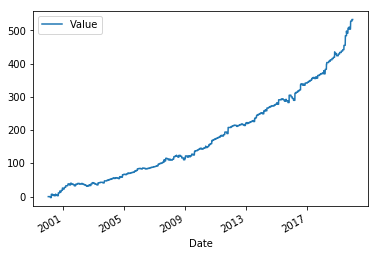

In [112]:
pf_df.plot()